# Local Field Potential (LFP) Analysis

This tutorial demonstrates comprehensive LFP analysis using the ``braintools.metric`` module. We'll cover:

1. **LFP Generation** - Converting spike trains to LFP signals
2. **Power Spectral Analysis** - Frequency domain characterization
3. **Coherence Analysis** - Cross-signal relationships
4. **Phase-Amplitude Coupling** - Cross-frequency interactions
5. **Current Source Density** - Laminar analysis
6. **Spectral Entropy** - Signal complexity measures
7. **Phase Coherence** - Multi-channel synchronization

## Setup

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import brainstate
import jax.numpy as jnp
import braintools

# Set environment
brainstate.environ.set(dt=0.1)
brainstate.random.seed(42)

# Plotting setup
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

## 1. LFP Generation from Spike Trains

First, let's generate realistic LFP signals from spike train data using the unitary LFP method.

In [13]:
# Simulation parameters
n_time = 5000  # 500ms at 0.1ms resolution
n_exc = 80     # Excitatory neurons
n_inh = 20     # Inhibitory neurons
dt = 0.1       # ms
times = jnp.arange(n_time) * dt

# Generate realistic spike trains with bursting activity
exc_spikes = jnp.zeros((n_time, n_exc))
inh_spikes = jnp.zeros((n_time, n_inh))

# Add burst events every ~50ms with some jitter
burst_times = jnp.arange(200, n_time, 500) + brainstate.random.randint(-50, 50, size=10)
for burst_t in burst_times:
    if burst_t < n_time - 50:
        # Excitatory burst (5-10 spikes over 20ms)
        for i in range(n_exc):
            if brainstate.random.random() < 0.6:  # 60% participation
                spike_times = burst_t + brainstate.random.randint(0, 20, size=brainstate.random.randint(2, 8))
                spike_times = spike_times[spike_times < n_time]
                exc_spikes = exc_spikes.at[spike_times, i].set(1)
        
        # Inhibitory response (delayed 5-15ms)
        for i in range(n_inh):
            if brainstate.random.random() < 0.8:  # 80% participation
                delay = brainstate.random.randint(5, 15)
                spike_times = burst_t + delay + brainstate.random.randint(0, 10, size=brainstate.random.randint(3, 6))
                spike_times = spike_times[spike_times < n_time]
                inh_spikes = inh_spikes.at[spike_times, i].set(1)

# Add background activity
background_exc = (brainstate.random.random((n_time, n_exc)) < 0.005).astype(float)
background_inh = (brainstate.random.random((n_time, n_inh)) < 0.008).astype(float)

exc_spikes = jnp.clip(exc_spikes + background_exc, 0, 1)
inh_spikes = jnp.clip(inh_spikes + background_inh, 0, 1)

print(f"Generated spike trains:")
print(f"  Excitatory: {jnp.sum(exc_spikes)} spikes from {n_exc} neurons")
print(f"  Inhibitory: {jnp.sum(inh_spikes)} spikes from {n_inh} neurons")

Generated spike trains:
  Excitatory: 3967.0 spikes from 80 neurons
  Inhibitory: 1360.0 spikes from 20 neurons


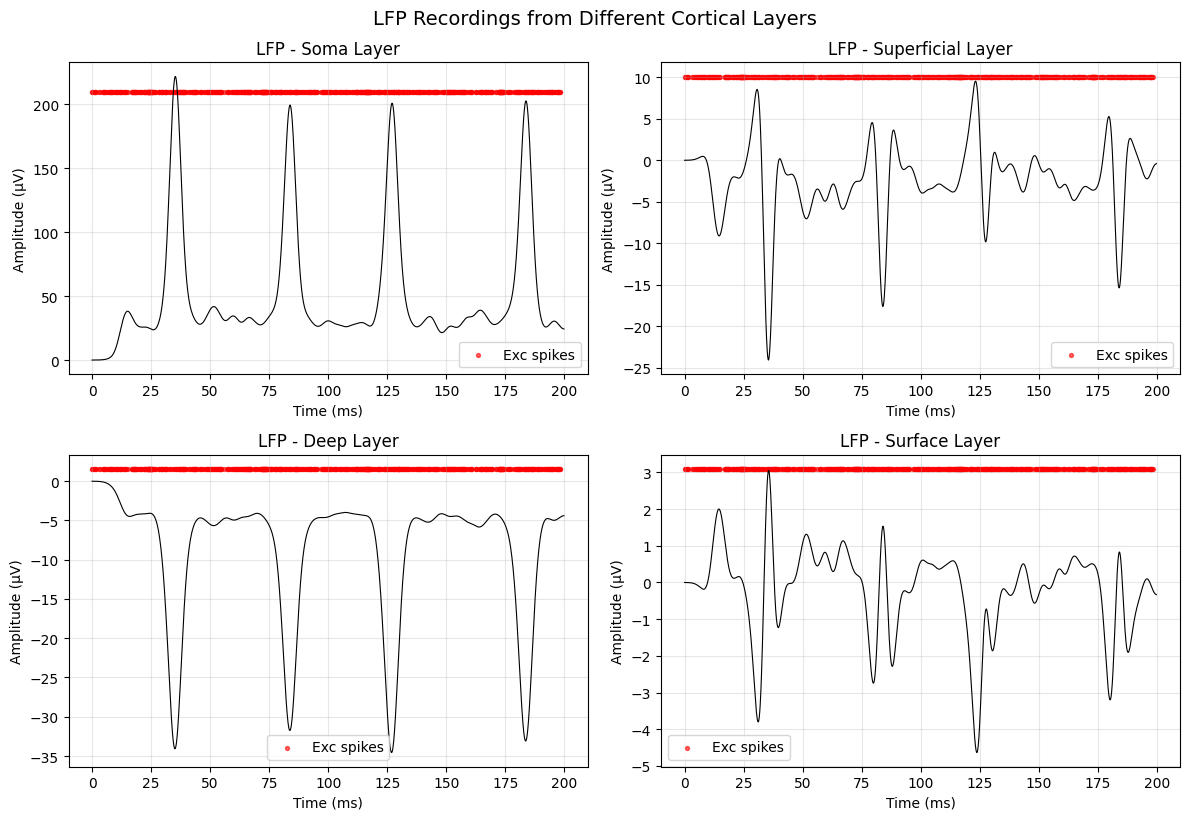

In [14]:
# Generate LFP signals from different cortical layers
locations = ['soma layer', 'superficial layer', 'deep layer', 'surface layer']
lfp_recordings = {}

for location in locations:
    # Generate LFP from both populations
    lfp_exc = braintools.metric.unitary_LFP(times, exc_spikes, 'exc', location=location, seed=42)
    lfp_inh = braintools.metric.unitary_LFP(times, inh_spikes, 'inh', location=location, seed=42)
    lfp_total = lfp_exc + lfp_inh
    lfp_recordings[location] = lfp_total

# Plot LFP recordings from different layers
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, (location, lfp) in enumerate(lfp_recordings.items()):
    # Plot first 200ms for clarity
    time_window = times[:2000]
    lfp_window = lfp[:2000]
    
    axes[i].plot(time_window, lfp_window, 'k-', linewidth=0.8)
    axes[i].set_title(f'LFP - {location.title()}')
    axes[i].set_xlabel('Time (ms)')
    axes[i].set_ylabel('Amplitude (μV)')
    axes[i].grid(True, alpha=0.3)
    
    # Add spike raster overlay for context
    spike_times = jnp.where(jnp.sum(exc_spikes[:2000], axis=1) > 0)[0] * dt
    if len(spike_times) > 0:
        y_min, y_max = axes[i].get_ylim()
        axes[i].scatter(spike_times, [y_max * 0.9] * len(spike_times), 
                       c='red', s=8, alpha=0.6, label='Exc spikes')
        axes[i].legend()

plt.tight_layout()
plt.suptitle('LFP Recordings from Different Cortical Layers', y=1.02, fontsize=14)
plt.show()

# Use soma layer LFP for subsequent analysis
lfp_signal = lfp_recordings['soma layer']
dt_sec = dt / 1000  # Convert to seconds for frequency analysis

## 2. Power Spectral Density Analysis

Analyze the frequency content of LFP signals.

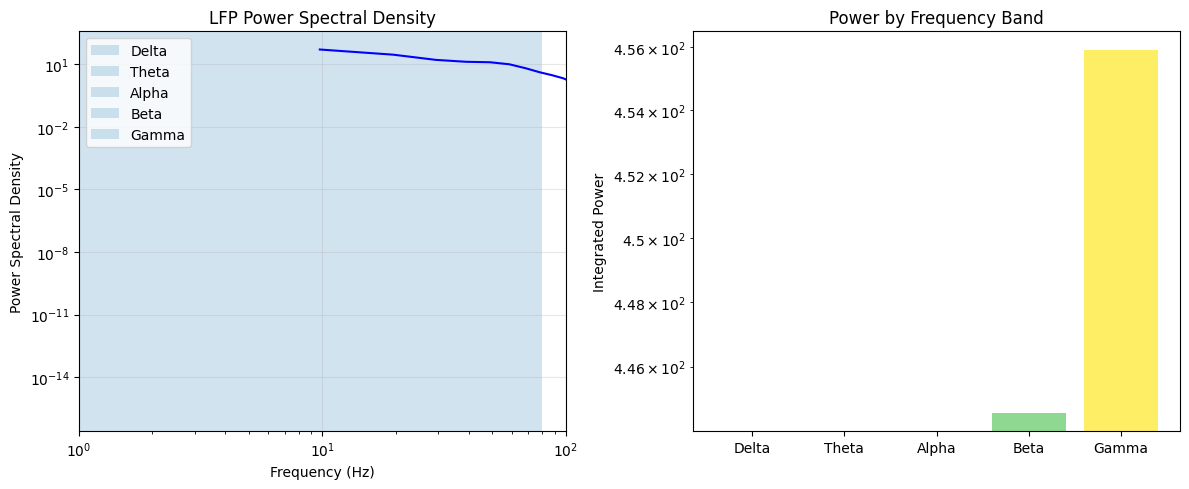


 Frequency Band Analysis:
  Delta : 0.000e+00 power units
  Theta : 0.000e+00 power units
  Alpha : 0.000e+00 power units
  Beta  : 4.446e+02 power units
  Gamma : 4.559e+02 power units

 Spectral Entropy: 0.831 (0=regular, 1=random)


In [15]:
# Compute power spectral density
freqs, psd = braintools.metric.power_spectral_density(lfp_signal, dt_sec)

# Analyze specific frequency bands
bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 80)
}

band_powers = {}
for band_name, (f_min, f_max) in bands.items():
    freqs_band, psd_band = braintools.metric.power_spectral_density(
        lfp_signal, dt_sec, freq_range=(f_min, f_max)
    )
    band_power = jnp.sum(psd_band) * (freqs_band[1] - freqs_band[0])  # Integrate power
    band_powers[band_name] = float(band_power)

# Plot results with fixed figure size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Full spectrum
ax1.loglog(freqs[1:], psd[1:], 'b-', linewidth=1.5)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power Spectral Density')
ax1.set_title('LFP Power Spectral Density')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, 100)

# Add frequency band annotations
for band_name, (f_min, f_max) in bands.items():
    ax1.axvspan(f_min, f_max, alpha=0.2, label=band_name)
ax1.legend()

# Band power comparison
band_names = np.asarray(list(band_powers.keys()))
powers = np.asarray(list(band_powers.values()))
colors = plt.cm.viridis(np.linspace(0, 1, len(bands)))

bars = ax2.bar(band_names, powers, color=colors, alpha=0.7)
ax2.set_ylabel('Integrated Power')
ax2.set_title('Power by Frequency Band')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print("\n Frequency Band Analysis:")
for band, power in band_powers.items():
    print(f"  {band:6s}: {power:.3e} power units")

# Compute spectral entropy as a complexity measure
entropy = braintools.metric.spectral_entropy(lfp_signal, dt_sec, freq_range=(1, 100))
print(f"\n Spectral Entropy: {entropy:.3f} (0=regular, 1=random)")

In [16]:
band_names.shape

(5,)

## 3. Coherence Analysis

Analyze the frequency-domain relationship between two LFP signals.

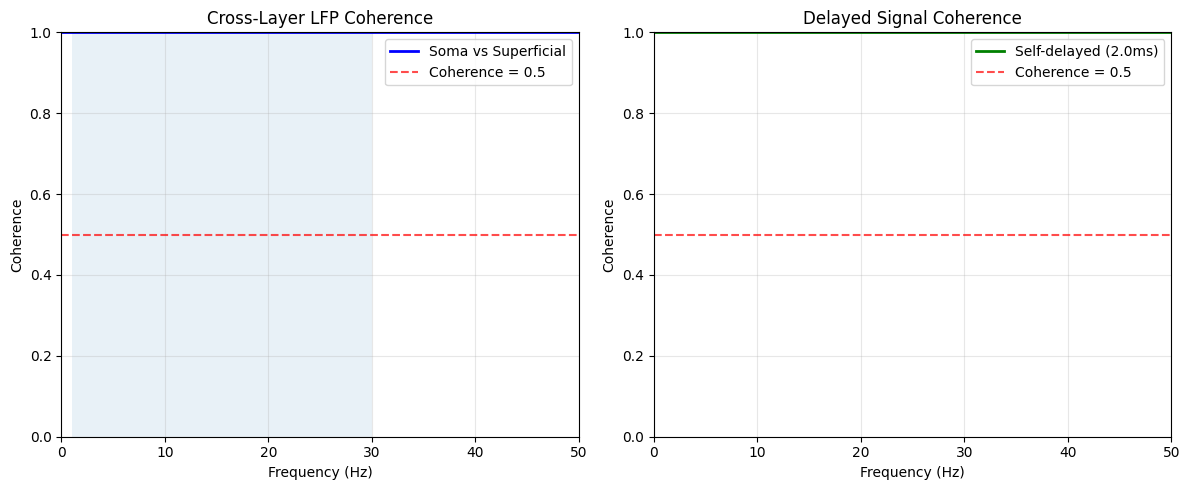


 Coherence in Frequency Bands:
  Alpha : 1.000
  Beta  : 1.000


In [17]:
# Use LFP from two different layers for coherence analysis
lfp1 = lfp_recordings['soma layer']
lfp2 = lfp_recordings['superficial layer']

# Compute coherence
freqs_coh, coherence = braintools.metric.coherence_analysis(lfp1, lfp2, dt_sec)

# Also compare with a delayed version of the same signal
delay_samples = 20  # 2ms delay
lfp1_delayed = jnp.concatenate([jnp.zeros(delay_samples), lfp1[:-delay_samples]])
freqs_delay, coherence_delay = braintools.metric.coherence_analysis(lfp1, lfp1_delayed, dt_sec)

# Plot coherence analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Cross-layer coherence
ax1.plot(freqs_coh, coherence, 'b-', linewidth=2, label='Soma vs Superficial')
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Coherence = 0.5')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Coherence')
ax1.set_title('Cross-Layer LFP Coherence')
ax1.set_xlim(0, 50)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add frequency band backgrounds
for band_name, (f_min, f_max) in bands.items():
    if f_max <= 50:
        ax1.axvspan(f_min, f_max, alpha=0.1)

# Delayed signal coherence
ax2.plot(freqs_delay, coherence_delay, 'g-', linewidth=2, label=f'Self-delayed ({delay_samples*dt:.1f}ms)')
ax2.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Coherence = 0.5')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Coherence')
ax2.set_title('Delayed Signal Coherence')
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Compute coherence in specific frequency bands
print("\n Coherence in Frequency Bands:")
for band_name, (f_min, f_max) in bands.items():
    if f_max <= 50:  # Within our analysis range
        band_mask = (freqs_coh >= f_min) & (freqs_coh <= f_max)
        if jnp.sum(band_mask) > 0:
            mean_coherence = jnp.mean(coherence[band_mask])
            print(f"  {band_name:6s}: {mean_coherence:.3f}")

## 4. Phase-Amplitude Coupling (PAC)

Analyze cross-frequency coupling, particularly theta-gamma coupling.

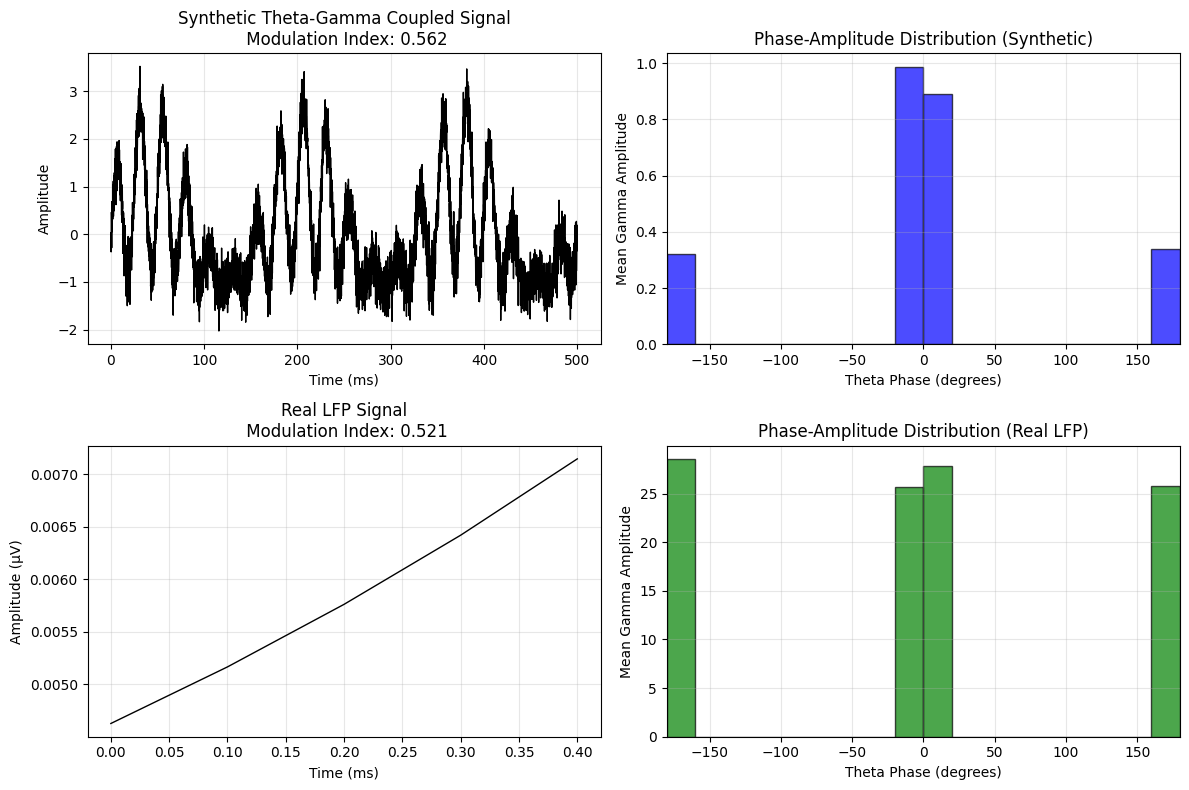


 Phase-Amplitude Coupling Analysis:
  Synthetic signal MI: 0.562
  Real LFP signal MI:  0.521
  Theta-gamma coupling: 0.521

   Modulation Index interpretation:
    0.0 = No coupling
    1.0 = Perfect coupling
    >0.1 = Significant coupling in experimental data


In [18]:
# Create a synthetic signal with theta-gamma coupling for demonstration
t_demo = jnp.arange(0, 4, dt_sec)  # 4 seconds
theta_freq = 6  # Hz
gamma_freq = 40  # Hz

# Generate coupled signal
theta_phase = 2 * jnp.pi * theta_freq * t_demo
theta_signal = jnp.sin(theta_phase)

# Gamma amplitude modulated by theta phase
gamma_amplitude = 1 + 0.8 * theta_signal  # Strong coupling
gamma_signal = gamma_amplitude * jnp.sin(2 * jnp.pi * gamma_freq * t_demo)

# Add some noise
noise = 0.3 * brainstate.random.normal(size=len(t_demo))
coupled_signal = theta_signal + gamma_signal + noise

# Analyze PAC in synthetic signal
mi_synthetic, phase_bins, mean_amps = braintools.metric.phase_amplitude_coupling(
    coupled_signal, dt_sec, phase_freq_range=(4, 8), amplitude_freq_range=(30, 50)
)

# Analyze PAC in real LFP signal
mi_real, phase_bins_real, mean_amps_real = braintools.metric.phase_amplitude_coupling(
    lfp_signal, dt_sec, phase_freq_range=(4, 8), amplitude_freq_range=(30, 80)
)

# Compute theta-gamma coupling specifically
theta_gamma_coupling = braintools.metric.theta_gamma_coupling(lfp_signal, dt_sec)

# Plot PAC analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Synthetic signal
time_window = t_demo[:int(0.5/dt_sec)]  # First 500ms
ax1.plot(time_window*1000, coupled_signal[:len(time_window)], 'k-', linewidth=1)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Amplitude')
ax1.set_title(f'Synthetic Theta-Gamma Coupled Signal\n Modulation Index: {mi_synthetic:.3f}')
ax1.grid(True, alpha=0.3)

# Phase-amplitude distribution (synthetic)
ax2.bar(phase_bins * 180/jnp.pi, mean_amps, width=360/len(phase_bins), 
        alpha=0.7, color='blue', edgecolor='black')
ax2.set_xlabel('Theta Phase (degrees)')
ax2.set_ylabel('Mean Gamma Amplitude')
ax2.set_title('Phase-Amplitude Distribution (Synthetic)')
ax2.set_xlim(-180, 180)
ax2.grid(True, alpha=0.3)

# Real LFP signal
time_window_real = times[:int(0.5/dt)]  # First 500ms
ax3.plot(time_window_real, lfp_signal[:len(time_window_real)], 'k-', linewidth=1)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Amplitude (μV)')
ax3.set_title(f'Real LFP Signal\n Modulation Index: {mi_real:.3f}')
ax3.grid(True, alpha=0.3)

# Phase-amplitude distribution (real)
ax4.bar(phase_bins_real * 180/jnp.pi, mean_amps_real, width=360/len(phase_bins_real), 
        alpha=0.7, color='green', edgecolor='black')
ax4.set_xlabel('Theta Phase (degrees)')
ax4.set_ylabel('Mean Gamma Amplitude')
ax4.set_title('Phase-Amplitude Distribution (Real LFP)')
ax4.set_xlim(-180, 180)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Phase-Amplitude Coupling Analysis:")
print(f"  Synthetic signal MI: {mi_synthetic:.3f}")
print(f"  Real LFP signal MI:  {mi_real:.3f}")
print(f"  Theta-gamma coupling: {theta_gamma_coupling:.3f}")
print("\n   Modulation Index interpretation:")
print("    0.0 = No coupling")
print("    1.0 = Perfect coupling")
print("    >0.1 = Significant coupling in experimental data")

## 5. Current Source Density (CSD) Analysis

Analyze laminar current sources and sinks from multi-electrode LFP recordings.

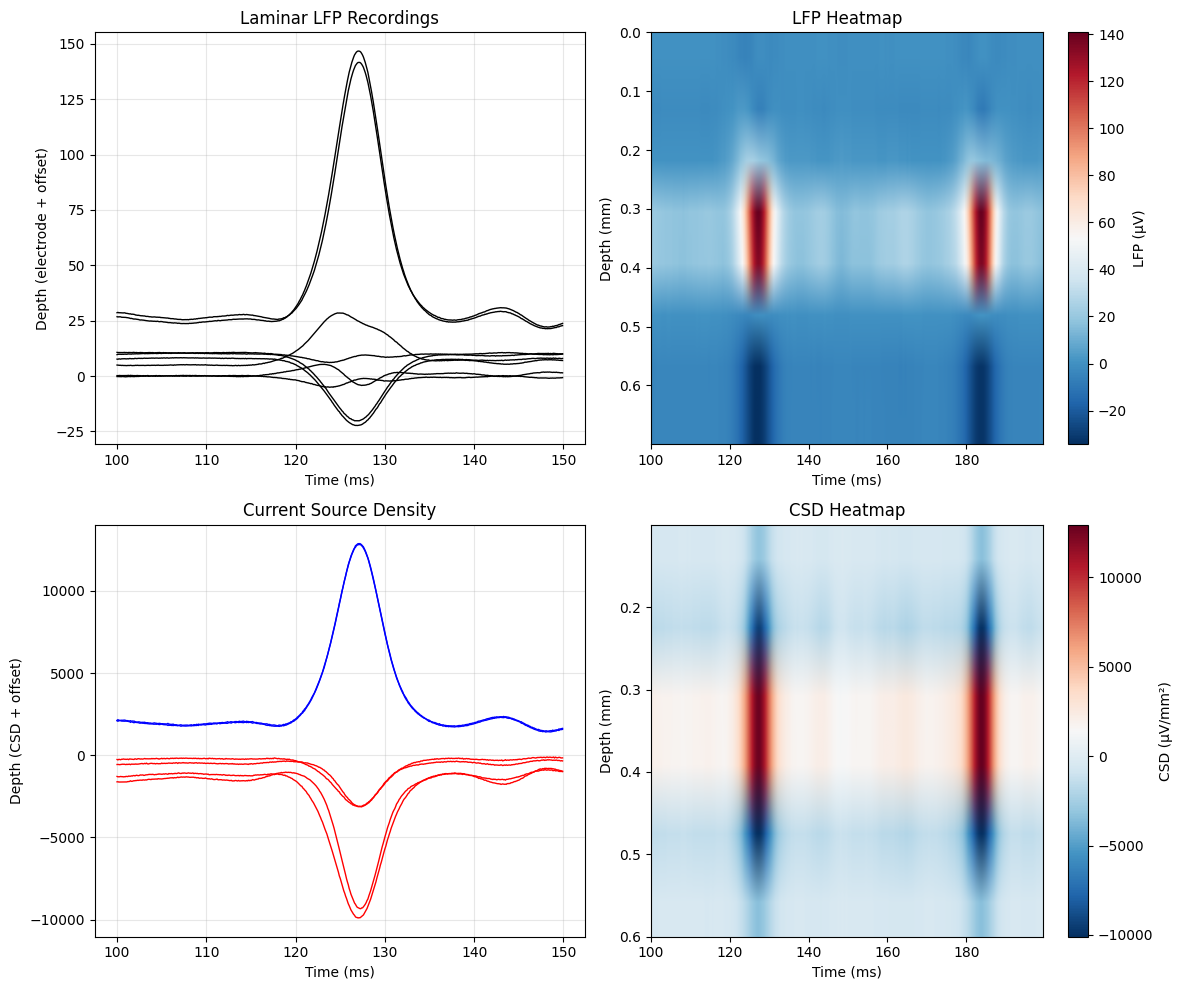


 Current Source Density Analysis:
  Electrode spacing: 0.1 mm
  Number of LFP channels: 8
  Number of CSD channels: 6 (boundary electrodes excluded)
  CSD depth range: 0.1 - 0.6 mm
  Depth 0.1mm: -755.20 ± 743.54 (sink)
  Depth 0.2mm: -2265.40 ± 2230.32 (sink)
  Depth 0.3mm: 3151.64 ± 2999.26 (source)
  Depth 0.4mm: 3152.19 ± 2999.30 (source)
  Depth 0.5mm: -2515.75 ± 2380.32 (sink)
  Depth 0.6mm: -838.69 ± 793.65 (sink)


In [19]:
# Create laminar LFP data (simulate linear electrode array)
electrode_spacing = 0.1  # mm
n_electrodes = 8
depths = jnp.arange(n_electrodes) * electrode_spacing

# Generate LFP at different depths using existing layer recordings
# and interpolate to create a realistic laminar profile
layer_lfps = jnp.array([
    lfp_recordings['surface layer'],
    lfp_recordings['superficial layer'],
    lfp_recordings['soma layer'],
    lfp_recordings['deep layer']
])

# Interpolate to create 8-electrode laminar recording
laminar_lfp = jnp.zeros((n_time, n_electrodes))
for i in range(n_electrodes):
    # Weight contributions from different layers based on depth
    depth_ratio = i / (n_electrodes - 1)
    
    if depth_ratio < 0.25:  # Surface
        weight = 1 - depth_ratio * 4
        laminar_lfp = laminar_lfp.at[:, i].set(
            weight * layer_lfps[0] + (1-weight) * layer_lfps[1]
        )
    elif depth_ratio < 0.5:  # Superficial
        weight = 1 - (depth_ratio - 0.25) * 4
        laminar_lfp = laminar_lfp.at[:, i].set(
            weight * layer_lfps[1] + (1-weight) * layer_lfps[2]
        )
    elif depth_ratio < 0.75:  # Soma
        weight = 1 - (depth_ratio - 0.5) * 4
        laminar_lfp = laminar_lfp.at[:, i].set(
            weight * layer_lfps[2] + (1-weight) * layer_lfps[3]
        )
    else:  # Deep
        laminar_lfp = laminar_lfp.at[:, i].set(layer_lfps[3])

# Add some gradient and noise for realism
for i in range(n_electrodes):
    # Add depth-dependent baseline shift
    baseline_shift = (i - n_electrodes/2) * 0.1
    noise = 0.05 * brainstate.random.normal(size=n_time)
    laminar_lfp = laminar_lfp.at[:, i].add(baseline_shift + noise)

# Compute current source density
csd = braintools.metric.current_source_density(laminar_lfp, electrode_spacing)
csd_depths = depths[1:-1]  # CSD excludes boundary electrodes

# Plot laminar analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Raw LFP traces
time_window = slice(1000, 1500)  # 50ms window
time_axis = times[time_window]

for i in range(n_electrodes):
    offset = i * 2  # Vertical offset for display
    ax1.plot(time_axis, laminar_lfp[time_window, i] + offset, 
             'k-', linewidth=1, label=f'Ch{i+1}')

ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Depth (electrode + offset)')
ax1.set_title('Laminar LFP Recordings')
ax1.grid(True, alpha=0.3)

# LFP color plot
time_indices = jnp.arange(1000, 2000, 5)  # Subsample for visualization
im1 = ax2.imshow(laminar_lfp[time_indices].T, aspect='auto', 
                 extent=[times[time_indices[0]], times[time_indices[-1]], 
                        depths[-1], depths[0]], 
                 cmap='RdBu_r', interpolation='bilinear')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Depth (mm)')
ax2.set_title('LFP Heatmap')
plt.colorbar(im1, ax=ax2, label='LFP (μV)')

# CSD traces
for i in range(csd.shape[1]):
    offset = i * 50  # Larger offset for CSD
    ax3.plot(time_axis, csd[time_window, i] + offset, 
             'b-' if jnp.mean(csd[:, i]) > 0 else 'r-', 
             linewidth=1, label=f'CSD{i+1}')

ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Depth (CSD + offset)')
ax3.set_title('Current Source Density')
ax3.grid(True, alpha=0.3)

# CSD color plot
im2 = ax4.imshow(csd[time_indices].T, aspect='auto',
                 extent=[times[time_indices[0]], times[time_indices[-1]], 
                        csd_depths[-1], csd_depths[0]], 
                 cmap='RdBu_r', interpolation='bilinear')
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('Depth (mm)')
ax4.set_title('CSD Heatmap')
plt.colorbar(im2, ax=ax4, label='CSD (μV/mm²)')

plt.tight_layout()
plt.show()

print("\n Current Source Density Analysis:")
print(f"  Electrode spacing: {electrode_spacing} mm")
print(f"  Number of LFP channels: {n_electrodes}")
print(f"  Number of CSD channels: {csd.shape[1]} (boundary electrodes excluded)")
print(f"  CSD depth range: {csd_depths[0]:.1f} - {csd_depths[-1]:.1f} mm")

# Analyze CSD statistics
for i, depth in enumerate(csd_depths):
    csd_mean = jnp.mean(csd[:, i])
    csd_std = jnp.std(csd[:, i])
    source_or_sink = "source" if csd_mean > 0 else "sink"
    print(f"  Depth {depth:.1f}mm: {csd_mean:6.2f} ± {csd_std:.2f} ({source_or_sink})")

## 6. Multi-Channel Phase Coherence Analysis

Analyze phase relationships across multiple LFP channels.

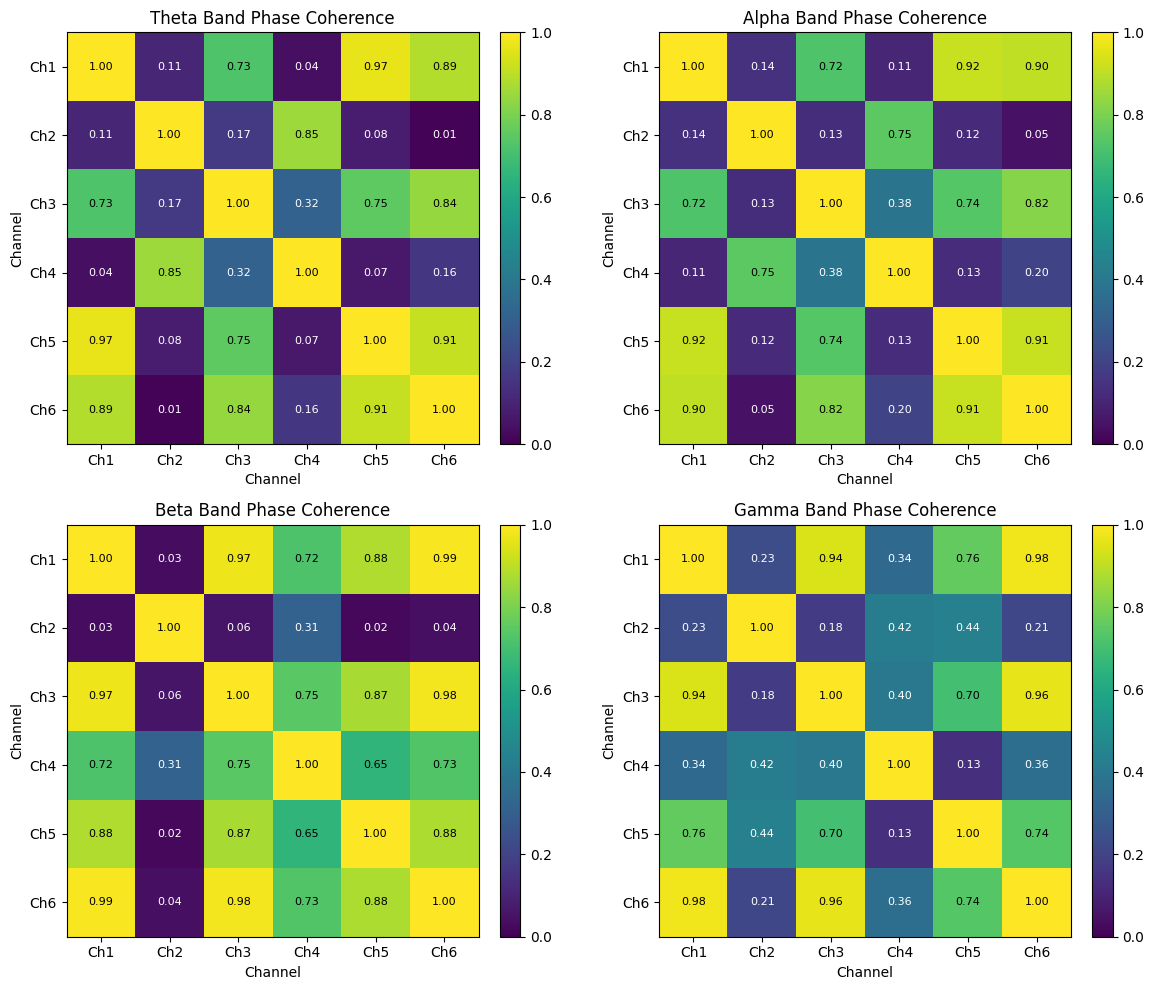


 Phase Coherence Network Analysis:

   Theta Band:
    Mean coherence: 0.458
    Max coherence: 0.967 (Ch1-Ch5)
    Network density (>0.5): 14/30 pairs

   Alpha Band:
    Mean coherence: 0.469
    Max coherence: 0.917 (Ch1-Ch5)
    Network density (>0.5): 14/30 pairs

   Beta Band:
    Mean coherence: 0.592
    Max coherence: 0.990 (Ch1-Ch6)
    Network density (>0.5): 20/30 pairs

   Gamma Band:
    Mean coherence: 0.520
    Max coherence: 0.978 (Ch1-Ch6)
    Network density (>0.5): 12/30 pairs


In [20]:
# Create multi-channel LFP dataset
n_channels = 6
multi_lfp = jnp.zeros((n_time, n_channels))

# Use existing layer recordings and add some synthetic channels
base_signals = [
    lfp_recordings['soma layer'],
    lfp_recordings['superficial layer'],
    lfp_recordings['deep layer'],
    lfp_recordings['surface layer']
]

# Create 6 channels with varying degrees of correlation
for i in range(n_channels):
    if i < len(base_signals):
        multi_lfp = multi_lfp.at[:, i].set(base_signals[i])
    else:
        # Create synthetic channels with phase relationships
        if i == 4:  # Phase-shifted version of channel 0
            shift_samples = 15  # 1.5ms shift
            shifted = jnp.concatenate([jnp.zeros(shift_samples),
                                       base_signals[0][:-shift_samples]])
            noise = 0.2 * brainstate.random.normal(size=n_time)
            multi_lfp = multi_lfp.at[:, i].set(shifted + noise)
        else:  # Mixed signal
            mixed = 0.6 * base_signals[0] + 0.4 * base_signals[1]
            noise = 0.3 * brainstate.random.normal(size=n_time)
            multi_lfp = multi_lfp.at[:, i].set(mixed + noise)

# Analyze phase coherence in different frequency bands
freq_bands = {
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 50)
}

coherence_matrices = {}
for band_name, freq_band in freq_bands.items():
    coh_matrix = braintools.metric.lfp_phase_coherence(multi_lfp, dt_sec, freq_band=freq_band)
    coherence_matrices[band_name] = coh_matrix

# Plot phase coherence matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (band_name, coh_matrix) in enumerate(coherence_matrices.items()):
    im = axes[i].imshow(coh_matrix, cmap='viridis', vmin=0, vmax=1,
                        interpolation='nearest')
    axes[i].set_title(f'{band_name} Band Phase Coherence')
    axes[i].set_xlabel('Channel')
    axes[i].set_ylabel('Channel')

    # Add colorbar
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    # Add text annotations
    for j in range(n_channels):
        for k in range(n_channels):
            text = f'{coh_matrix[j, k]:.2f}'
            axes[i].text(k, j, text, ha="center", va="center",
                         color="white" if coh_matrix[j, k] < 0.5 else "black",
                         fontsize=8)

    # Set ticks
    axes[i].set_xticks(range(n_channels))
    axes[i].set_yticks(range(n_channels))
    axes[i].set_xticklabels([f'Ch{j + 1}' for j in range(n_channels)])
    axes[i].set_yticklabels([f'Ch{j + 1}' for j in range(n_channels)])

plt.tight_layout()
plt.show()

# Analyze network connectivity
print("\n Phase Coherence Network Analysis:")
for band_name, coh_matrix in coherence_matrices.items():
    # Mean coherence (excluding diagonal)
    off_diag_mask = ~jnp.eye(n_channels, dtype=bool)
    mean_coherence = jnp.mean(coh_matrix[off_diag_mask])

    # Most coherent pair
    off_diag_coh = coh_matrix.copy().at[jnp.diag_indices(n_channels)].set(0)
    max_idx = jnp.unravel_index(jnp.argmax(off_diag_coh), coh_matrix.shape)
    max_coherence = coh_matrix[max_idx]

    print(f"\n   {band_name} Band:")
    print(f"    Mean coherence: {mean_coherence:.3f}")
    print(f"    Max coherence: {max_coherence:.3f} (Ch{max_idx[0] + 1}-Ch{max_idx[1] + 1})")
    print(f"    Network density (>0.5): {jnp.sum(off_diag_coh > 0.5)}/{jnp.sum(off_diag_mask)} pairs")

## 7. Summary and Comparison of LFP Metrics

Let's summarize all the LFP analysis metrics we've computed.

            LFP ANALYSIS SUMMARY

 1. SIGNAL CHARACTERISTICS:
   Duration: 500.0 ms
   Sampling rate: 10000.0 Hz
   Number of excitatory neurons: 80
   Number of inhibitory neurons: 20
   Total spikes: 5327

 2. POWER SPECTRAL ANALYSIS:
   Delta : 0.00e+00 ( 0.0%)
   Theta : 0.00e+00 ( 0.0%)
   Alpha : 0.00e+00 ( 0.0%)
   Beta  : 4.45e+02 (49.4%)
   Gamma : 4.56e+02 (50.6%)
   Spectral entropy: 0.831

 3. CROSS-FREQUENCY COUPLING:
   Theta-gamma PAC (real): 0.521
   Theta-gamma coupling: 0.521
   Synthetic PAC (demo): 0.562

 4. COHERENCE ANALYSIS:
   Cross-layer coherence: 0.259
   Delayed signal coherence: 0.428

 5. LAMINAR ANALYSIS:
   Electrode spacing: 0.1 mm
   CSD depth range: 0.1 - 0.6 mm
   Current sources: 2/6 channels
   Current sinks: 4/6 channels

 6. MULTI-CHANNEL PHASE COHERENCE:
   Theta : 0.458 mean, 14/30 pairs >0.5
   Alpha : 0.469 mean, 14/30 pairs >0.5
   Beta  : 0.592 mean, 20/30 pairs >0.5
   Gamma : 0.520 mean, 12/30 pairs >0.5

         END OF LFP ANALYSIS


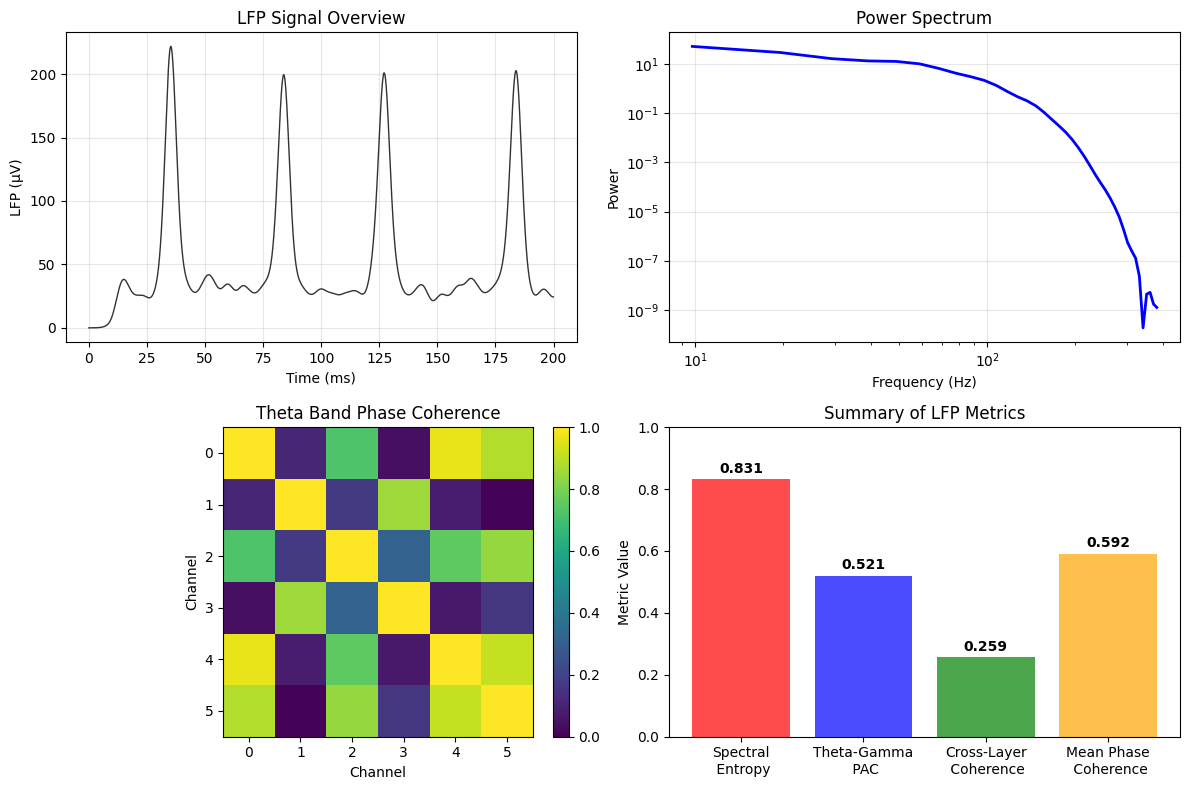


 This tutorial demonstrated comprehensive LFP analysis capabilities:
• LFP generation from spike trains with spatial modeling
• Power spectral density analysis across frequency bands
• Coherence analysis between signals
• Phase-amplitude coupling detection
• Current source density from laminar recordings
• Spectral entropy as complexity measure
• Multi-channel phase coherence networks

 These tools provide a complete toolkit for LFP analysis in computational neuroscience.


In [21]:
# Create summary comparison
print("=" * 60)
print("            LFP ANALYSIS SUMMARY")
print("=" * 60)

print("\n 1. SIGNAL CHARACTERISTICS:")
print(f"   Duration: {n_time * dt:.1f} ms")
print(f"   Sampling rate: {1000/dt:.1f} Hz")
print(f"   Number of excitatory neurons: {n_exc}")
print(f"   Number of inhibitory neurons: {n_inh}")
print(f"   Total spikes: {int(jnp.sum(exc_spikes) + jnp.sum(inh_spikes))}")

print("\n 2. POWER SPECTRAL ANALYSIS:")
for band, power in band_powers.items():
    percentage = (power / sum(band_powers.values())) * 100
    print(f"   {band:6s}: {power:8.2e} ({percentage:4.1f}%)")
print(f"   Spectral entropy: {entropy:.3f}")

print("\n 3. CROSS-FREQUENCY COUPLING:")
print(f"   Theta-gamma PAC (real): {mi_real:.3f}")
print(f"   Theta-gamma coupling: {theta_gamma_coupling:.3f}")
print(f"   Synthetic PAC (demo): {mi_synthetic:.3f}")

print("\n 4. COHERENCE ANALYSIS:")
mean_cross_layer_coh = jnp.mean(coherence)
print(f"   Cross-layer coherence: {mean_cross_layer_coh:.3f}")
print(f"   Delayed signal coherence: {jnp.mean(coherence_delay):.3f}")

print("\n 5. LAMINAR ANALYSIS:")
print(f"   Electrode spacing: {electrode_spacing} mm")
print(f"   CSD depth range: {csd_depths[0]:.1f} - {csd_depths[-1]:.1f} mm")
source_channels = jnp.sum(jnp.mean(csd, axis=0) > 0)
sink_channels = jnp.sum(jnp.mean(csd, axis=0) < 0)
print(f"   Current sources: {source_channels}/{csd.shape[1]} channels")
print(f"   Current sinks: {sink_channels}/{csd.shape[1]} channels")

print("\n 6. MULTI-CHANNEL PHASE COHERENCE:")
for band_name, coh_matrix in coherence_matrices.items():
    off_diag_mask = ~jnp.eye(n_channels, dtype=bool)
    mean_coh = jnp.mean(coh_matrix[off_diag_mask])
    high_coh_pairs = jnp.sum(coh_matrix[off_diag_mask] > 0.5)
    total_pairs = jnp.sum(off_diag_mask)
    print(f"   {band_name:6s}: {mean_coh:.3f} mean, {high_coh_pairs}/{total_pairs} pairs >0.5")

print("\n " + "=" * 60)
print("         END OF LFP ANALYSIS")
print("=" * 60)

# Create a final overview plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Signal overview
time_overview = times[:2000]  # First 200ms
ax1.plot(time_overview, lfp_signal[:2000], 'k-', linewidth=1, alpha=0.8)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('LFP (μV)')
ax1.set_title('LFP Signal Overview')
ax1.grid(True, alpha=0.3)

# Power spectrum
ax2.loglog(freqs[1:40], psd[1:40], 'b-', linewidth=2)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Power')
ax2.set_title('Power Spectrum')
ax2.grid(True, alpha=0.3)

# Phase coherence summary (theta band)
theta_coh = coherence_matrices['Theta']
im = ax3.imshow(theta_coh, cmap='viridis', vmin=0, vmax=1)
ax3.set_title('Theta Band Phase Coherence')
ax3.set_xlabel('Channel')
ax3.set_ylabel('Channel')
plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)

# Metrics summary
metrics = ['Spectral\n Entropy', 'Theta-Gamma\n PAC', 'Cross-Layer\n Coherence', 'Mean Phase\n Coherence']
values = [entropy, theta_gamma_coupling, mean_cross_layer_coh, jnp.mean(jnp.array(list(coherence_matrices.values())))]
colors = ['red', 'blue', 'green', 'orange']

bars = ax4.bar(metrics, values, color=colors, alpha=0.7)
ax4.set_ylabel('Metric Value')
ax4.set_title('Summary of LFP Metrics')
ax4.set_ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n This tutorial demonstrated comprehensive LFP analysis capabilities:")
print("• LFP generation from spike trains with spatial modeling")
print("• Power spectral density analysis across frequency bands")
print("• Coherence analysis between signals")
print("• Phase-amplitude coupling detection")
print("• Current source density from laminar recordings")
print("• Spectral entropy as complexity measure")
print("• Multi-channel phase coherence networks")
print("\n These tools provide a complete toolkit for LFP analysis in computational neuroscience.")